In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [29]:
%pwd
img_folder='C:\\Users\\Nithin Kodipyaka\\Downloads\\Compressed\\resized\\'

In [30]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5','char6'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        df.loc[i,'char6'] = f.split('.')[0][5]
        i = i+1


In [31]:
df.to_csv('ml_proj.csv')

In [32]:
df=pd.read_csv("ml_proj.csv")

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7 non-null      int64 
 1   filename    7 non-null      object
 2   extension   7 non-null      object
 3   label       7 non-null      int64 
 4   labelsize   7 non-null      int64 
 5   char1       7 non-null      int64 
 6   char2       7 non-null      int64 
 7   char3       7 non-null      int64 
 8   char4       7 non-null      int64 
 9   char5       7 non-null      int64 
 10  char6       7 non-null      int64 
dtypes: int64(9), object(2)
memory usage: 744.0+ bytes


In [34]:
df.value_counts()

Unnamed: 0  filename    extension  label   labelsize  char1  char2  char3  char4  char5  char6
0           101547.png  png        101547  6          1      0      1      5      4      7        1
1           101548.png  png        101548  6          1      0      1      5      4      8        1
2           101549.png  png        101549  6          1      0      1      5      4      9        1
3           101553.png  png        101553  6          1      0      1      5      5      3        1
4           101563.png  png        101563  6          1      0      1      5      6      3        1
5           101564.png  png        101564  6          1      0      1      5      6      4        1
6           126841.png  png        126841  6          1      2      6      8      4      1        1
dtype: int64

In [37]:
char_to_num = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9
               ,'a':10,'b':11,'c':12,'d':13,'e':14,'f':15,'g':16,'h':17,'i':18,
              'j':19,'k':20,'l':21,'m':22,'n':23,'o':24,'p':25,'q':26,'r':27,
               's':28,'t':29,'u':30,'v':31,'w':32,'x':33,'y':34,'z':35}

In [38]:
def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1) 
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150
    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=75, target_height=100, target_width=145)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)
    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 6 integers. E.g. '6n6ggg' is converted into [6,16,6,14,14,14]
    label = list(map(lambda x:char_to_num[x], label))
    return img.numpy(), label


In [39]:
img_folder = "C:\\Users\\Nithin Kodipyaka\\Downloads\\Compressed\\resized\\"

X, y = [],[]
crop=False
for _, _, files in os.walk(img_folder):
    for f in files:
        # To start, let's ignore the jpg images
        label = f.split('.')[0]
        extension = f.split('.')[1]
        if extension=='png':
            img, label = encode_single_sample(img_folder+f, label,crop)
            X.append(img)
            y.append(label)

X = np.array(X)
y=np.array(y)

(-0.5, 49.5, 199.5, -0.5)

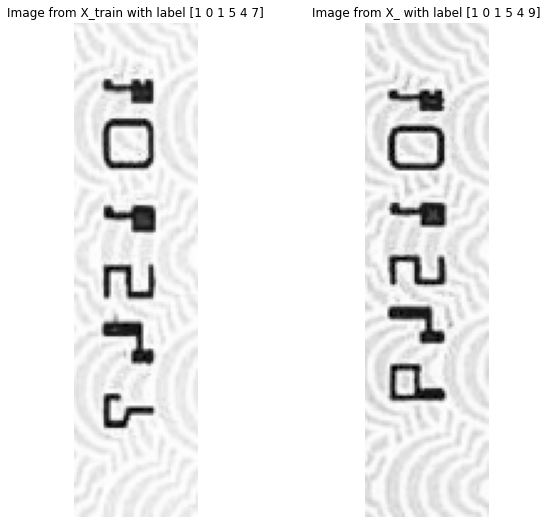

In [40]:
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(2, 4, 1)
plt.imshow(X[0], cmap='gray')
plt.title('Image from X_train with label '+ str(y[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X[2], cmap='gray')
plt.title('Image from X_ with label '+ str(y[2]))
plt.axis('off')

In [43]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(6, 6400), name="reshape")(x)

    # FC layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(128, activation="relu", name="dense2")(x)
    x = layers.Dense(64, activation="relu", name="dense3")(x)
    output = layers.Dense(36, activation="softmax", name="dense4")(x) 
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 6, 6400)           0         
                                                                 
 dense1 (Dense)              (None, 6, 2

In [48]:
history = model.fit(x=X, y=y,  epochs=50)

Epoch 1/50
1/1 [==============================] - 0s 96ms/step - loss: 0.2260 - accuracy: 0.9286
Epoch 2/50
1/1 [==============================] - 0s 96ms/step - loss: 0.2125 - accuracy: 0.9286
Epoch 3/50
1/1 [==============================] - 0s 96ms/step - loss: 0.2013 - accuracy: 0.9286
Epoch 4/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1921 - accuracy: 0.9286
Epoch 5/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1832 - accuracy: 0.9524
Epoch 6/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1824 - accuracy: 0.9048
Epoch 7/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1723 - accuracy: 0.9762
Epoch 8/50
1/1 [==============================] - 0s 88ms/step - loss: 0.1592 - accuracy: 0.9524
Epoch 9/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1555 - accuracy: 0.9286
Epoch 10/50
1/1 [==============================] - 0s 96ms/step - loss: 0.1501 - accuracy: 0.9524
Epoch 11/50
1/1 [============

In [49]:
model.save_weights('./checkpoints/my_checkpoint')

In [50]:
df

,Unnamed: 0,filename,extension,label,labelsize,char1,char2,char3,char4,char5,char6
0,0,101547.png,png,101547,6,1,0,1,5,4,7
1,1,101548.png,png,101548,6,1,0,1,5,4,8
2,2,101549.png,png,101549,6,1,0,1,5,4,9
3,3,101553.png,png,101553,6,1,0,1,5,5,3
4,4,101563.png,png,101563,6,1,0,1,5,6,3
5,5,101564.png,png,101564,6,1,0,1,5,6,4
6,6,126841.png,png,126841,6,1,2,6,8,4,1


In [54]:
y_pred = model.predict(X)
y_pred = np.argmax(y_pred,axis=2)

1/1 [==============================] - 0s 58ms/step


In [55]:
y_pred

array([[1, 0, 1, 5, 4, 7],
       [1, 0, 1, 5, 4, 8],
       [1, 0, 1, 5, 4, 9],
       [1, 0, 1, 5, 5, 3],
       [1, 0, 1, 5, 6, 3],
       [1, 0, 1, 5, 6, 4],
       [1, 2, 6, 8, 4, 1]], dtype=int64)

In [58]:
num_to_char = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9
               ,'10':'a','11':'b','12':'c','13':'d','14':'e','15':'f','16':'g','17':'h','18':'i',
               '19':'j','20':'k','21':'l','22':'m','23':'n','24':'o'
               ,'25':'p','26':'q','27':'r','28':'s','29':'t','30':'u','31':'v','32':'w','33':'x','34':'y','35':'z'}

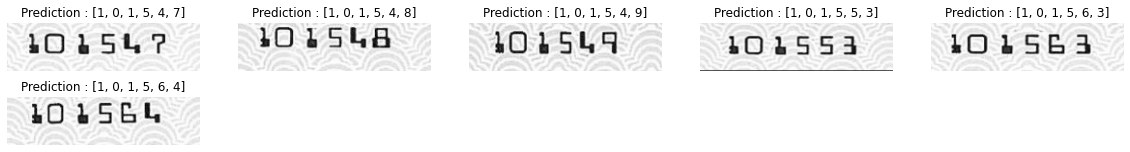

In [60]:
nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,6):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()